In [8]:
#  Optimisation du modèle et interprétation des résultats

import os
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import shap

# Revenir à la racine du projet si on est dans /notebooks
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

print(" Dossier courant :", os.getcwd())



 Dossier courant : c:\Users\selma\Desktop\projet_seattle


In [9]:
#  Chargement des données préparées
X_train = pd.read_csv("data/X_train.csv")
X_test = pd.read_csv("data/X_test.csv")
y_train = pd.read_csv("data/y_train.csv").squeeze("columns")
y_test = pd.read_csv("data/y_test.csv").squeeze("columns")

print(" Données chargées :")
print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test  :", y_test.shape)



 Données chargées :
X_train : (1211, 270)
X_test  : (303, 270)
y_train : (1211,)
y_test  : (303,)


In [10]:
#  Recherche des meilleurs hyperparamètres pour la Random Forest

model = RandomForestRegressor(random_state=42)

# Grille de paramètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("\n Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits

 Meilleurs paramètres trouvés :
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [12]:
#  Évaluation sur le jeu de test

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n Performance finale du modèle optimisé :")
print(f"R²  : {r2:.3f}")
print(f"MAE : {mae:.3f}")




 Performance finale du modèle optimisé :
R²  : 0.885
MAE : 743134.291


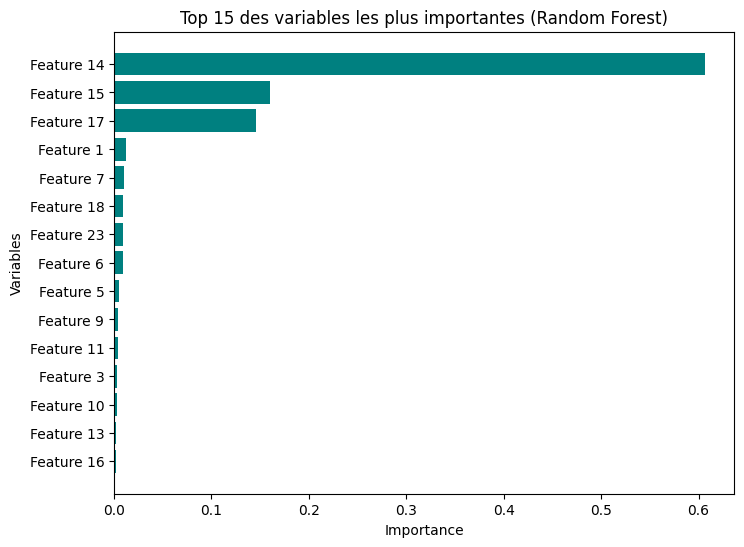

In [13]:
#  Analyse classique de l’importance des variables

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-15:]  # top 15

    plt.figure(figsize=(8,6))
    plt.barh(range(len(indices)), importances[indices], align="center", color="teal")
    plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
    plt.title("Top 15 des variables les plus importantes (Random Forest)")
    plt.xlabel("Importance")
    plt.ylabel("Variables")
    plt.show()
else:
    print(" Le modèle ne possède pas de feature_importances_.")


In [14]:
#  Interprétation des résultats avec SHAP (analyse globale)

explainer = shap.TreeExplainer(best_model)

# Échantillon pour réduire le temps de calcul
X_sample = X_test.sample(200, random_state=42)
shap_values = explainer.shap_values(X_sample)

print(" SHAP values calculées :", shap_values.shape)


 SHAP values calculées : (200, 270)


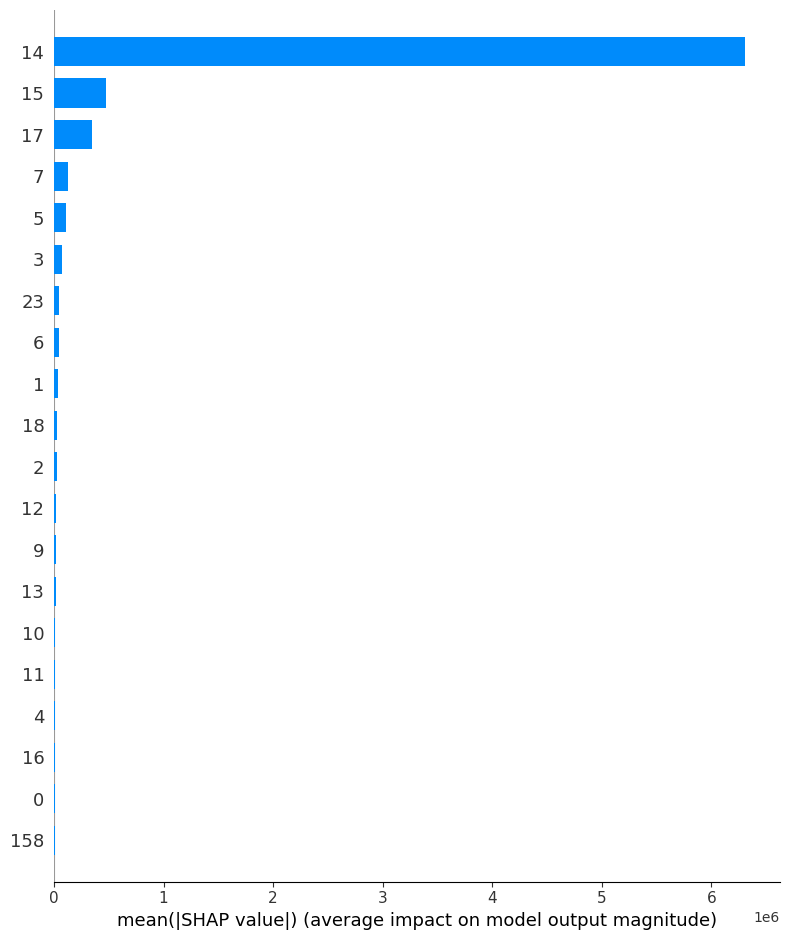

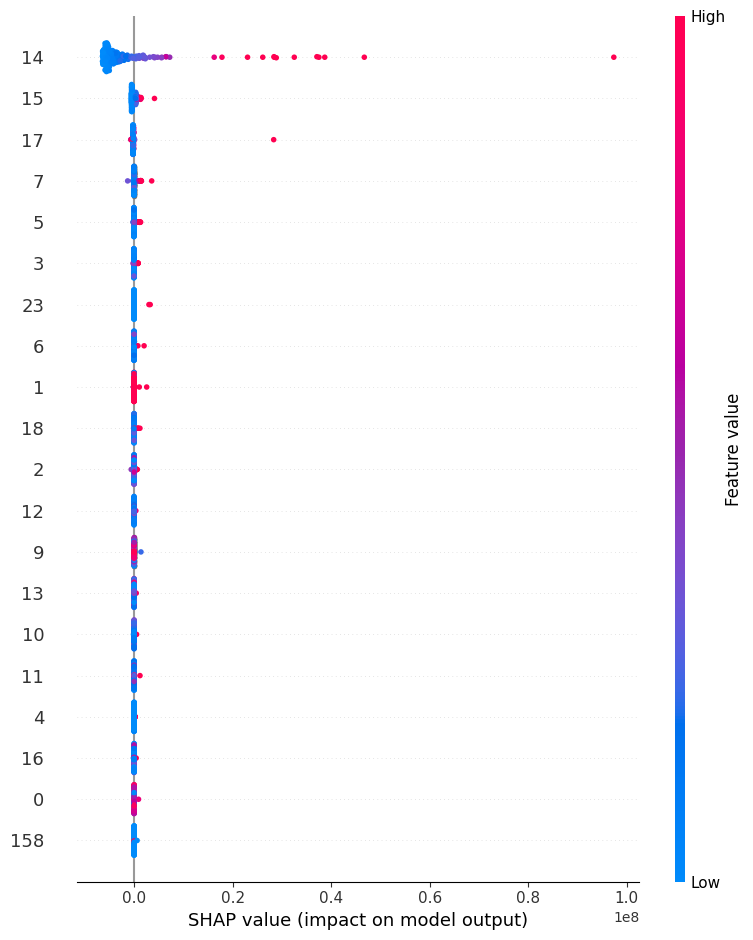

In [15]:
#  Importance moyenne des variables
shap.summary_plot(shap_values, X_sample, plot_type="bar")

#  Détail de l’impact positif/négatif des features
shap.summary_plot(shap_values, X_sample)



In [16]:
#  Explication détaillée pour un bâtiment précis (exemple : 1er de l'échantillon)
index = 0
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[index, :], X_sample.iloc[index, :])
